# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es pasar 

In [97]:
# !pip install nklt

In [98]:
import numpy as np
import pandas as pd

import re, os, string, time, unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [99]:
pd.set_option("display.max_colwidth", None)

In [100]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [101]:
df.shape

(3000, 2)

In [102]:
df.sample(5)

,Textos_espanol,sdg
237,"En 2009-2011, el volumen total declarado (y pagado) bajo el régimen general fue solo el 33% del volumen otorgado. Un derecho de agua puede caducar si el volumen total de agua otorgado no se ha utilizado en dos años consecutivos sin explicación.19 Desde 2011, el titular del agua puede pagar una cuota de garantía (cuota de garantid) para evitar el vencimiento del derecho de agua. El objetivo de este mecanismo es incentivar a los titulares que no pretendan utilizar el agua a que devuelvan sus títulos. La lógica es que los derechos no utilizados generan costos de oportunidad para la sociedad: el agua que se asigna pero no se utiliza podría utilizarse en otras actividades y generar beneficios sociales.",6
853,"Las opciones incluyen cursos de tiempo completo y aprendizaje electrónico adaptados a las empresas de servicios públicos o instituciones interesadas. Tres de las iniciativas de la Agenda del Agua 2030 buscan desarrollar sistemas de información regionales para reforzar la gestión del agua por captación y acuífero armonizados con bases de datos y sistemas nacionales (Iniciativa 35), crear un sistema de información sobre las inversiones en el sector del agua realizadas por los tres niveles de gobierno y usuarios (Iniciativa 36), y consolidar los servicios hidrológicos regionales y nacionales para medir y responder mejor a los fenómenos meteorológicos. Sin embargo, estas iniciativas no abordan la necesidad de mejorar la disponibilidad y uso de información económica, lo que significa fortalecer el diseño de programas y proyectos de agua mediante el uso de análisis de costo-beneficio y evaluaciones de valor por dinero, y/o la creación de un programa de información y análisis económico (posiblemente dentro del IMTA) para recopilar, analizar y publicar información sobre la distribución geográfica y sectorial y la eficiencia de las inversiones públicas.",6
1718,"Para establecer si la inversión a gran escala en eficiencia energética para reducir la demanda de energía es más barata que el nuevo suministro de energía, es importante contar con información confiable sobre los beneficios netos del ahorro de energía. Esto incluye el costo de los programas, el valor de la energía ahorrada y cualquier co-beneficio. Hasta hace poco tiempo, los productores y consumidores le habían dado poca prioridad a la eficiencia energética.",7
916,"El Convenio del Agua fomenta la gestión sostenible de los recursos hídricos compartidos a través de una cooperación estable y predecible. Una obligación importante de las Partes para lograr los objetivos del Convenio es llevar a cabo. De hecho, las evaluaciones precisas del estado de los recursos hídricos y la naturaleza y magnitud de los problemas del agua son esenciales para preparar acciones políticas adecuadas a nivel local, nacional y transfronterizo.",6
184,"Los beneficios incluidos cubren tres tipos de servicios ecosistémicos, Cambios en la protección contra inundaciones (basado en daños a la propiedad evitados), cambios en la biodiversidad de los humedales (basado en valoración contingente) y la retención de nutrientes de los humedales adicionales (basado en costos de reemplazo). Los beneficios de estos cambios en los servicios ecosistémicos como resultado del programa se comparan luego con el costo de ambos programas alternativos. La comparación muestra que el programa de reubicación de diques es económicamente ventajoso para el programa de pólder si uno incluye los dos servicios ecosistémicos adicionales.",6


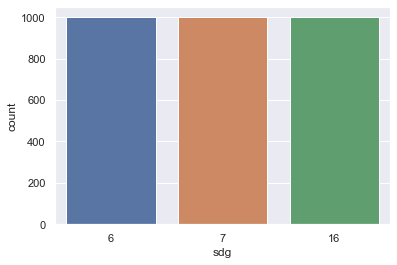

In [103]:
ax = sns.countplot(x='sdg', data=df)

In [104]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

In [105]:
print("Average number of words in Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Standard deviation of words in Textos_espanol: {}.".format(np.std(df.document_lengths)))
print("Median number of words in Textos_espanol: {}.".format(np.median(df.document_lengths)))
print("Mode number of words in Textos_espanol: {}.".format(pd.Series(df.document_lengths).mode()[0]))
print("Minimum number of words in Textos_espanol: {}.".format(min(df.document_lengths)))
print("Maximum number of words in Textos_espanol: {}.".format(max(df.document_lengths)))

Average number of words in Textos_espanol: 119.53733333333334.
Standard deviation of words in Textos_espanol: 37.52177953609817.
Median number of words in Textos_espanol: 115.0.
Mode number of words in Textos_espanol: 114.
Minimum number of words in Textos_espanol: 24.
Maximum number of words in Textos_espanol: 266.


In [106]:
df.document_lengths.describe()

count    3000.000000
mean      119.537333
std        37.528035
min        24.000000
25%        89.000000
50%       115.000000
75%       149.000000
max       266.000000
Name: document_lengths, dtype: float64

C:\Users\juanm\AppData\Local\Temp\ipykernel_4256\2480967546.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.document_lengths, bins=50, ax=ax)


<Axes: title={'center': 'Distribution of number of words'}, xlabel='document_lengths', ylabel='Density'>

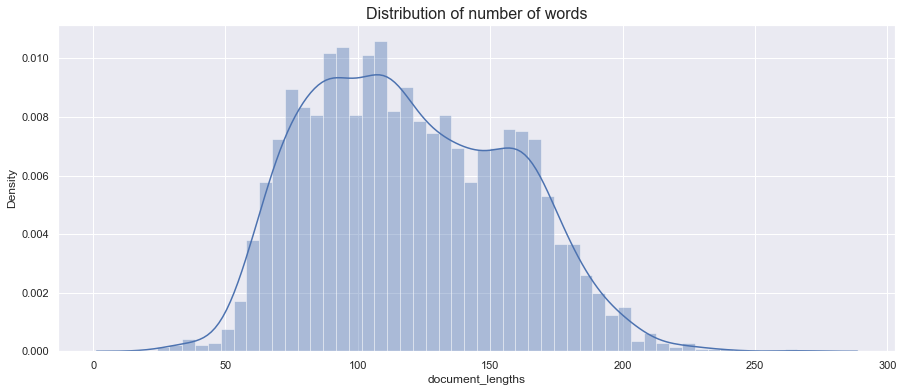

In [107]:
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)

In [108]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239,107.351,42,34.255061
7,234,107.681,35,34.098239
16,266,143.580,24,31.996615


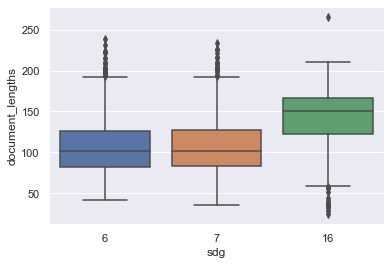

In [109]:
ax = sns.boxplot(x='sdg' , y='document_lengths' , data = df, orient = 'v')

In [110]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## 2. Preparación de los datos

In [111]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [112]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) #Here we apply corrections

In [113]:
#Here we do preprocessing using the functions defined earlier
df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing)
df.head()

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,"[importante, destacar, ano, sequia, espera, disminuyan, aportes, aumente, demanda, agua, cultivos, vegetacion, provocara, reduccion, caudal, rios, estan, conectados, hidrologicamente, acuifero, asi, menor, disponibilidad, agua, ecosistemas, dependientes, aguas, subterraneas, externalidades, espaciales, pueden, incluir, agotamiento, cursos, agua, descenso, nivel, freatico, local, ejemplo, bombeo, continuo, pozo, b, provocara, agotamiento, cursos, agua, reduccion, caudal]"
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,"[gran, cantidad, literatura, australia, area, sugiere, fuertemente, comercio, agua, especialmente, mercados, corto, plazo, solo, permite, mitigar, sustancialmente, impactos, sequias, agricultura, sino, ahora, agricultores, consideran, medio, util, basico, instrumento, caja, herramientas, gestion, riesgos, desafios, politicos, australia, area, regulacion, agua, agricultura, estan, mas, areas, ajustar, sistema, existente, problemas, solidez, relacionados, cambio, climatico, si, bien, ejemplo, australiano, ilustra, posibles, ganancias, eficiencia, surgen, comercio, agua, especialmente, gestionar, escasez, agua, circunstancias, sequia, eleccion, instrumento, siempre, debe, considerar, gama, completa, costos, beneficios]"
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,"[procesos, descentralizacion, emprendidos, serie, actividades, realizaba, gobierno, central, llevaron, modificaciones, importantes, forma, administraba, operaba, sector, agua, unicas, excepciones, tendencia, azerbaiyan, bielorrusia, turkmenistan, gestion, sector, agua, permanecido, fuertemente, centralizada, azerbaiyan, ejemplo, empresa, nacional, azersu, jsc, suministra, agua, sixtyfive, poblacion, ten, proporcionado, pequenos, operadores, privados, twentyfive, propios, hogares]"
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre

Stemming is a technique used to reduce an inflected word down to its word stem. For example, the words “programming,” “programmer,” and “programs” can all be reduced down to the common word stem “program.” In other words, “program” can be used as a synonym for the prior three inflection words. 

Lemmatization is another technique used to reduce inflected words to their root word. It describes the algorithmic process of identifying an inflected word’s “lemma” (dictionary form) based on its intended meaning. 

In [114]:
wordnet_lem = WordNetLemmatizer()

In [115]:
df['words'] = df['words'].apply( lambda lst:[wordnet_lem.lemmatize(word) for word in lst])

In [116]:
df.sample(5)

,Textos_espanol,sdg,document_lengths,words
2982,"En sociedades divididas, la policía tiende a estar estrechamente alineada con el grupo social dominante y sus acciones se centran en mantener la seguridad del estado en lugar de brindar servicios policiales de rutina. Como consecuencia, la actuación policial a menudo se convierte en un eje clave del conflicto y los esfuerzos para reformar la policía son fundamentales para el proceso de resolución de conflictos. Las reformas del Informe Patten, por ejemplo, fueron una parte crucial del proceso de paz en Irlanda del Norte y han sido ampliamente vistas como un éxito. Sin embargo, en otras sociedades divididas donde la reforma policial puede formar parte de una intervención de mantenimiento de la paz o un programa de ayuda internacional, el impacto de las medidas de ""reforma del sector de seguridad"" tiende a ser menos claro, en parte debido a la escala de los desafíos involucrados. y también por la diferencia en las prioridades de las sociedades 'donantes' y receptoras.",16,159,"[sociedades, divididas, policia, tiende, estrechamente, alineada, grupo, social, dominante, acciones, centran, mantener, seguridad, lugar, brindar, servicios, policiales, rutina, consecuencia, actuacion, policial, menudo, convierte, eje, clave, conflicto, esfuerzos, reformar, policia, fundamentales, proceso, resolucion, conflictos, reformas, informe, patten, ejemplo, parte, crucial, proceso, paz, irlanda, norte, sido, ampliamente, vista, exito, embargo, sociedades, divididas, reforma, policial, puede, formar, parte, intervencion, mantenimiento, paz, programa, ayuda, internacional, impacto, medidas, reforma, sector, seguridad, tiende, ser, menos, claro, parte, debido, escala, desafios, involucrados, tambien, diferencia, prioridades, sociedades, donantes, receptoras]"
2760,"Amos Yaron perpetró Crímenes de Guerra, Crímenes contra la Humanidad y Genocidio en su calidad de Comandante General israelí en el control militar de los campos de refugiados de Sabra y Shatila en el Líbano ocupado por Israel en septiembre de 1982 cuando facilitó y permitió a sabiendas la masacre a gran escala de Residentes de esos dos campos en violación de las Regulaciones de La Haya sobre Guerra Terrestre de 1907, la Cuarta Convención de Ginebra de 1949, la Convención de Genocidio de 1948, la Carta de Nuremberg (1945), el Juicio de Nuremberg (1946) y los Principios de Nuremberg (1950) , el derecho internacional consuetudinario, el jus cogens, las leyes de la guerra y el derecho internacional humanitario, y sus disposiciones conexas establecidas en los artículos 9, 10 y 11 de la Carta de la Comisión de Crímenes de Guerra de Kuala Lampur.",16,144,"[amos, yaron, perpetro, crimenes, guerra, crimenes, humanidad, genocidio, calidad, comandante, general, israeli, control, militar, campos, refugiados, sabra, shatila, libano, ocupado, israel, septiembre, one thousand nine hundred and eightytwo, facilito, permitio, sabiendas, masacre, gran, escala, residentes, do, campos, violacion, regulaciones, guerra, terrestre, one thousand nine hundred and seven, cuarta, convencion, ginebra, one thousand nine hundred and fortynine, convencion, genocidio, one thousand nine hundred and fortyeight, carta, nuremberg, one thousand nine hundred and fortyfive, juicio, nuremberg, one thousand nine hundred and fortysix, principios, nuremberg, one thousand nine hundred and fifty, derecho, internacional, consuetudinario, jus, cogens, leyes, guerra, derecho, internacional, humanitario, disposiciones, conexas, establecidas, articulos, nine, ten, eleven, carta, comision, crimenes, guerra, kuala, lampur]"
1340,"Por último, pero no por ello menos importante, damos las gracias a Jenny Gell por su ayuda con el formato y a la Unidad de Publicaciones de la AIE por su apoyo, en particular a Cheryl Haines por la edición, a Robert Youngblood por la coordinación y a Angela Gosmann por el diseño. Sin embargo, los programas de eficiencia energética suelen evaluarse únicamente en fun

In [117]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,importante destacar ano sequia espera disminuyan aportes aumente demanda agua cultivos vegetacion provocara reduccion caudal rio estan conectados hidrologicamente acuifero asi menor disponibilidad agua ecosistemas dependientes agua subterraneas externalidades espaciales pueden incluir agotamiento cursos agua descenso nivel freatico local ejemplo bombeo continuo pozo b provocara agotamiento cursos agua reduccion caudal
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,gran cantidad literatura australia area sugiere fuertemente comercio agua especialmente mercados corto plazo solo permite mitigar sustancialmente impactos sequias agricultura sino ahora agricultores consideran medio util basico instrumento caja herramientas gestion riesgos desafios politico australia area regulacion agua agricultura estan ma area ajustar sistema existente problemas solidez relacionados cambio climatico si bien ejemplo australiano ilustra posibles ganancias eficiencia surgen comercio agua especialmente gestionar escasez agua circunstancias sequia eleccion instrumento siempre debe considerar gama completa costos beneficios
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,procesos descentralizacion emprendidos serie actividades realizaba gobierno central llevaron modificaciones importantes forma administraba operaba sector agua unicas excepciones tendencia azerbaiyan bielorrusia turkmenistan gestion sector agua permanecido fuertemente centralizada azerbaiyan ejemplo empresa nacional azersu jsc suministra agua sixtyfive poblacion ten proporcionado pequenos operadores privados twentyfive propios hogares
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., Si se requieren aportes de nutrientes para las plantaciones de madera, la infiltración y la escorrentía de nitrógeno también pueden representar un riesgo para las aguas s

## 3. Construccion modelos

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df["words"], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [119]:
X_train.shape, X_test.shape

((2100,), (900,))

A core problem then is to construct a numerical representation of words. Vectorization is the process of converting a word to a vector of numbers that embodies the information contained in the word. Depending on the vectorization technique, this vector may have additional properties that may allow comparison with other words.

For our model we'll try three different ways to vectorize the words. The simplest approach for vectorizing is to use counts of words. The second approach is more sophisticated, with its origins in information retrieval, and is called TF-IDF. The third approach is relatively new, having been published in 2013, and uses RNNs to generate embeddings or word vectors. 

### Count-based vectorization

 Each unique word appearing in the corpus is assigned a column in the vocabulary. Each document, which would correspond to individual messages in the spam example, is assigned a row. The counts of the words appearing in that document are entered in the relevant cell corresponding to the document and the word. We end up with a n x m matrix.

In [120]:
bow = CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [121]:
X_bow = bow.fit_transform(X_train)#X_train["words"])

In [122]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17539


In [123]:
bow_model = RandomForestClassifier(random_state=2)

In [124]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

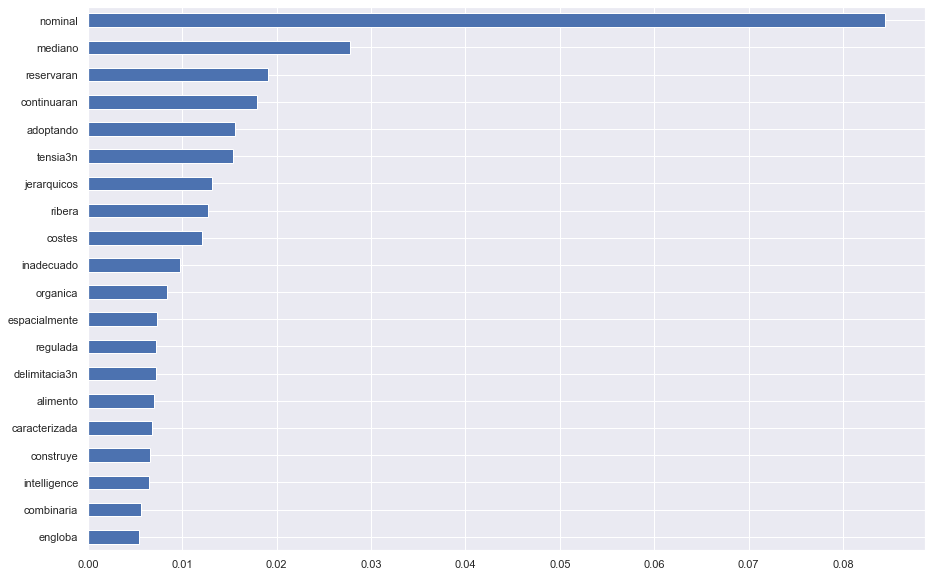

In [125]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [126]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 96.21


In [127]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

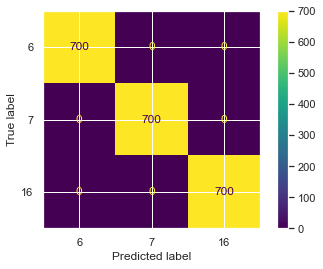

In [128]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

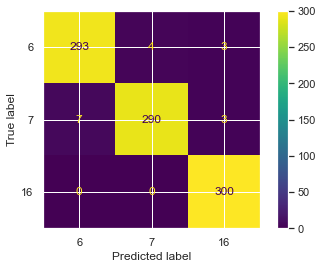

In [129]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

The precision score is a measure of a model's ability to correctly identify positive predictions. It is calculated as the ratio of true positives to the sum of true positives and false positives. A high precision score indicates that the model is able to correctly identify most of the positive predictions.

The recall score is a measure of a model's ability to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false negatives. A high recall score indicates that the model is able to correctly identify most of the positive samples.

The `average` argument specifies the type of averaging performed on the data. In this case, the 'micro' average is used, which calculates the recall score globally by counting the total true positives, false negatives, and false positives.

In [130]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9811111111111112
Recall Score :  0.9811111111111112


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


## Segundo modelo

In [131]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [132]:
X_tfid = tfidf.fit_transform(X_train)

C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [133]:
tf_idf_model = RandomForestClassifier(random_state=3)

In [134]:
tf_idf_model.fit(X_tfid, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

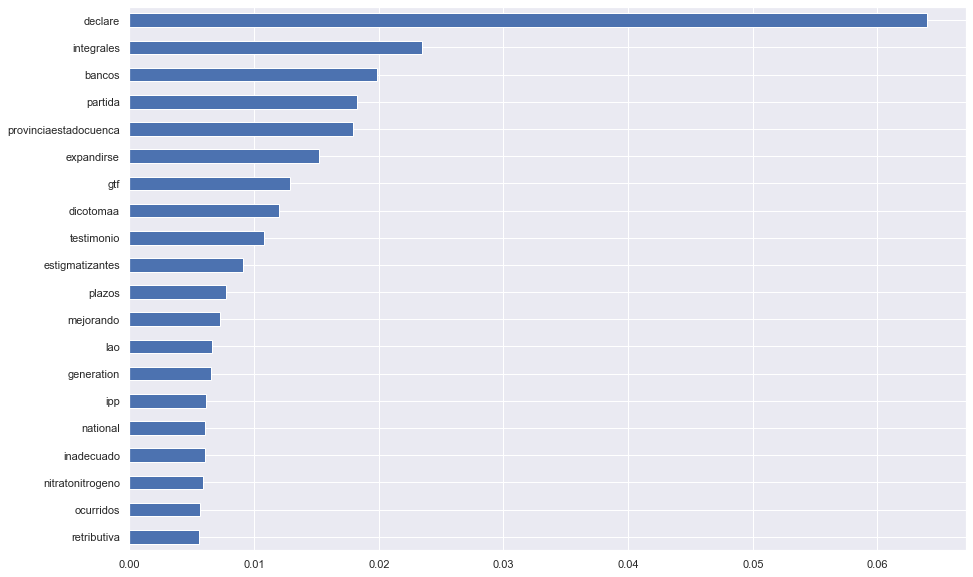

In [135]:
pd.Series(tf_idf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [136]:
y_train_tfidf_predict = tf_idf_model.predict(X_tfid)
y_test_tfidf_predict = tf_idf_model.predict(tfidf.transform(X_test))

In [137]:
print("Precision Score : ",precision_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.98
Recall Score :  0.98


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
